# Gradient descent on Soft-DTW metric metric using PyTorch

This notebook is inspired by the notebook of Romain Tavenard about the Soft Dynamic Time Warping (Soft-DTW) metric: 

https://github.com/rtavenar/notebooks-ml4ts/blob/main/02_softdtw_sol.ipynb

The aim here is to use the PyTorch backend to compute the gradient of the metric.

# Import the modules

In [12]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)
    
import time

import numpy as np
import matplotlib.pyplot as plt
import torch
from celluloid import Camera
from IPython.display import HTML

from tslearn.backend import instanciate_backend
from tslearn.metrics import SoftDTW, soft_dtw_alignment, SquaredEuclidean

# Introduction to Soft-DTW

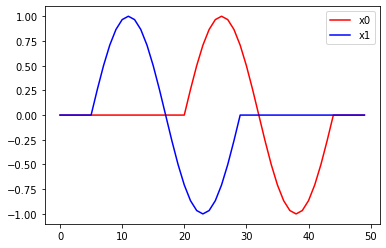

In [13]:
size = 50
x0 = np.zeros((size, ))
x0[20:20+size//2] = np.sin(np.linspace(0, 2 * np.pi, size // 2))

x1 = np.zeros((size, ))
x1[5:5+size//2] = np.sin(np.linspace(0, 2 * np.pi, size // 2))

plt.figure()
plt.plot(x0, 'r-', label='x0')  # red
plt.plot(x1, 'b-', label='x1')  # blue
plt.legend()
plt.show()


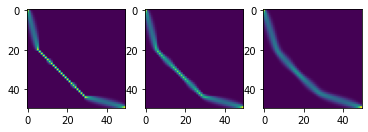

In [14]:
for i, gamma in enumerate([1e-3, 1e-1, 1.]):
    plt.subplot(1, 3, i + 1)
    A_gamma, dst = soft_dtw_alignment(x0, x1, gamma=gamma)
    plt.imshow(A_gamma)

# Gradient descent using the Soft-DTW metric

## On NumPy data computing with the NumPy backend

In [15]:
def soft_dtw_grad(x, y, gamma):    
    D = SquaredEuclidean(x.reshape((-1, 1)), y.reshape((-1, 1)))
    sdtw = SoftDTW(D, gamma=gamma)
    sdtw.compute()
    A_gamma = sdtw.grad()
    grad = D.jacobian_product(A_gamma)
    return grad

In [16]:
def animate_gradient_descent(list_of_successive_time_series, show_x1=False):
    fig = plt.figure()
    camera = Camera(fig)
    for x in list_of_successive_time_series:
        plt.plot(x.ravel(), 'k-')
        plt.plot(x0, 'r-', label='x0')
        if show_x1:
            plt.plot(x1, 'b-', label='x1')
        camera.snap()    
    anim = camera.animate()
    plt.close()
    return HTML(anim.to_jshtml())

In [17]:
eta = 1e-1
n_epochs = 100
gamma = .1

In [18]:
list_x = [.1 * np.random.randn(size, 1) + x0.reshape((-1, 1))]

start_time = time.time()
for i_epoch in range(n_epochs):
    x_t = list_x[-1]
    x_tp1 = x_t - eta * soft_dtw_grad(x_t, x0, gamma)
    list_x.append(x_tp1)
end_time = time.time()
execution_time = end_time - start_time
print('Execution time to compute gradient descent on Numpy data computing with the NumPy backend: ', execution_time)

animate_gradient_descent(list_x)

Execution time to compute gradient descent on Numpy data computing with the NumPy backend:  0.07953596115112305


## On PyTorch data computing with the NumPy backend

In [19]:
def soft_dtw_grad_pytorch(x, y, gamma, compute_with_backend):    
    D = SquaredEuclidean(x.reshape((-1, 1)), y.reshape((-1, 1)), be='pytorch', compute_with_backend=compute_with_backend)
    sdtw = SoftDTW(D, gamma=gamma, be='pytorch', compute_with_backend=compute_with_backend)
    sdtw.compute()
    A_gamma = sdtw.grad()
    grad = D.jacobian_product(A_gamma)
    return grad

In [20]:
be = instanciate_backend('pytorch')
x0 = be.array(x0)

list_x = [.1 * be.random.randn(size, 1) + be.reshape(x0, (-1, 1))]

start_time = time.time()
for i_epoch in range(n_epochs):
    x_t = list_x[-1]
    x_tp1 = x_t - eta * soft_dtw_grad_pytorch(x_t, x0, gamma, compute_with_backend=False)
    list_x.append(x_tp1)
end_time = time.time()
execution_time = end_time - start_time
print('Execution time to compute gradient descent on PyTorch data computing with the NumPy backend: ', execution_time)

animate_gradient_descent(list_x)

Execution time to compute gradient descent on PyTorch data computing with the NumPy backend:  0.32021260261535645


## On PyTorch data computing with the PyTorch backend

In [21]:
be = instanciate_backend('pytorch')
x0 = be.array(x0)

list_x = [.1 * be.random.randn(size, 1) + be.reshape(x0, (-1, 1))]

start_time = time.time()
for i_epoch in range(n_epochs):
    x_t = list_x[-1]
    x_tp1 = x_t - eta * soft_dtw_grad_pytorch(x_t, x0, gamma, compute_with_backend=True)
    list_x.append(x_tp1)
end_time = time.time()
execution_time = end_time - start_time
print('Execution time to compute gradient descent on PyTorch data computing with the NumPy backend: ', execution_time)

animate_gradient_descent(list_x)

Execution time to compute gradient descent on PyTorch data computing with the NumPy backend:  37.158294439315796


## On PyTorch data using PyTorch gradients (torch.tensor.grad)

In [22]:
be = instanciate_backend('pytorch')
x0 = be.array(x0)
# x0 = x0.clone().detach().requires_grad_(True)

x_t = .1 * be.random.randn(size, 1) + be.reshape(x0, (-1, 1))
list_x = [x_t.detach().clone()]
x_t = x_t.detach().clone().requires_grad_(True)

def criterion(x, y):
    D = SquaredEuclidean(x_t.reshape((-1, 1)), x0.reshape((-1, 1)), be='pytorch', compute_with_backend=True).compute()
    m, n = be.shape(D)
    sdtw = SoftDTW(D, gamma=gamma, be='pytorch', compute_with_backend=True)
    sdtw.compute()
    return sdtw.R_[m, n]

start_time = time.time()
execution_time_forward = 0
execution_time_backward = 0
execution_time_gradient_descent = 0
for i_epoch in range(n_epochs):
    start_time_forward = time.time()
    loss = criterion(x_t, x0)
    end_time_forward = time.time()
    execution_time_forward += end_time_forward - start_time_forward
    start_time_backward = time.time()
    loss.backward()
    end_time_backward = time.time()
    execution_time_backward += end_time_backward - start_time_backward
    with torch.no_grad():
        start_time_gradient_descent = time.time()
        x_t = x_t - eta * x_t.grad
        end_time_gradient_descent = time.time()
        execution_time_gradient_descent += end_time_gradient_descent - start_time_gradient_descent
        list_x.append(x_t.detach().clone())
        x_t.requires_grad = True
end_time = time.time()
execution_time = end_time - start_time
print('Execution time to compute gradient descent on PyTorch data using PyTorch gradients: ', execution_time)
print('Execution time gradient forward: ', execution_time_forward)
print('Execution time gradient backward: ', execution_time_backward)
print('Execution time gradient descent: ', execution_time_gradient_descent)

x0 = x0.detach().numpy()
animate_gradient_descent(list_x)

Execution time to compute gradient descent on PyTorch data using PyTorch gradients:  64.11174654960632
Execution time gradient forward:  28.703137159347534
Execution time gradient backward:  35.40290284156799
Execution time gradient descent:  0.0023806095123291016


# Conclusions

To perform a gradient descent on the Soft-DTW metric:
* The fastest method is to use the NumPy backend on NumPy data.
* On PyTorch data, it is faster to convert the Torch tensors into NumPy arrays, then perform the computations using Numba and convert back the results into Torch tensors than to perform the computations using the PyTorch backend. However, the Torch tensors lose their gradients when they are converted into NumPy arrays.
* In order to keep the PyTorch gradients, it is possible to perform the computations using the Pytorch backend on PyTorch data by setting the optional parameter of the classes 'SoftDTW' and 'SquaredEuclidean' named 'compute_with_backend' to True. However, this solution is slower.